<a href="https://colab.research.google.com/github/Kyezil/cs231n-solutions/blob/master/assignment1/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


### To cross check if notebook is running on GPU backend

In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Download and extract the required files

In [16]:
!rm -rf assignment1
!wget http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
!unzip spring1718_assignment1.zip
!rm spring1718_assignment1.zip
!cd ./assignment1 && ls

--2019-02-14 17:02:53--  http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.109.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73256 (72K) [application/zip]
Saving to: ‘spring1718_assignment1.zip’

spring1718_assignme 100%[===================>]  71.54K  --.-KB/s    in 0.02s   

2019-02-14 17:02:53 (3.48 MB/s) - ‘spring1718_assignment1.zip’ saved [73256/73256]

Archive:  spring1718_assignment1.zip
   creating: assignment1/
 extracting: assignment1/.gitignore  
   creating: assignment1/.ipynb_checkpoints/
  inflating: assignment1/.ipynb_checkpoints/features-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/knn-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/softmax-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/svm-checkpoint.ipynb  
  inf

### Downloading the dataset

In [17]:
!cd assignment1/cs231n/datasets && bash get_datasets.sh && ls

--2019-02-14 17:02:57--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  3.87MB/s    in 38s     

2019-02-14 17:03:35 (4.29 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
cifar-10-batches-py  get_datasets.sh


In [18]:
# Run some setup code for this notebook.

import random
import numpy as np
import os

os.chdir('assignment1')

from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [19]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


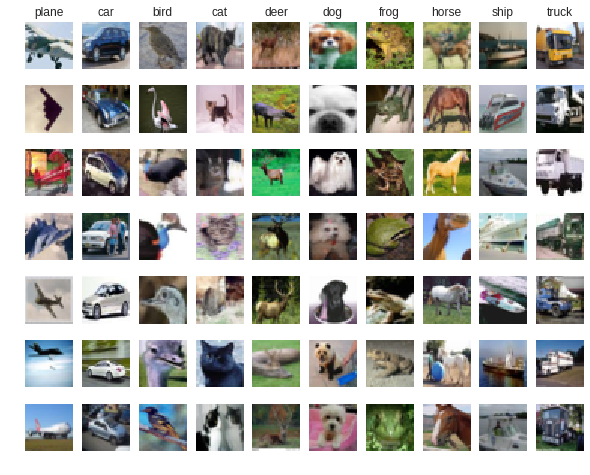

In [20]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [21]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [22]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


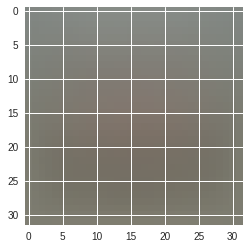

In [23]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [0]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [25]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


### Code from the classifiers/linear_svm.py file

In [0]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin
        dW[:,j] += X[i]
        dW[:,y[i]] -= X[i]

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW /= num_train

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)
  dW += reg * 2 * W

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################


  return loss, dW


def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  num_classes = W.shape[1]
  num_train = X.shape[0]
  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  # compute scores
  S = X @ W  # (N,C) score matrix
  # subtract correct score
  S_y = S[range(num_train), y] #(N,) correct score
  M = S - np.expand_dims(S_y, 1)
  # add margin
  M += 1
  M[range(num_train), y] = 0
  # max
  M = np.maximum(0,M)
  loss = np.sum(M) / num_train
  # add regularization
  loss += reg * np.sum(W*W)
  
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  
  I = (M > 0).astype(int) # I_ij => add X[i] to dW[:,j]
                          # (N,C)   sub X[i] to dW[:, y[i]]
  I[range(num_train), y] = -I.sum(axis=1)  # they should be 0 before
  dW += X.T @ I
  dW /= num_train
  # regularization term
  dW += 2 * reg * W
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [29]:
# Evaluate the naive implementation of the loss we provided for you:
# from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.803305


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [34]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.124236 analytic: -4.124236, relative error: 3.262717e-11
numerical: 7.132046 analytic: 7.132046, relative error: 5.658739e-11
numerical: 21.900989 analytic: 21.900989, relative error: 1.080366e-12
numerical: 27.846408 analytic: 27.846408, relative error: 1.175577e-11
numerical: 0.507086 analytic: 0.507086, relative error: 5.359114e-11
numerical: -17.253772 analytic: -17.253772, relative error: 8.091621e-12
numerical: 4.057244 analytic: 4.057244, relative error: 9.437352e-11
numerical: -8.623435 analytic: -8.623435, relative error: 1.071456e-11
numerical: 21.837159 analytic: 21.837159, relative error: 6.610632e-12
numerical: -6.741461 analytic: -6.741461, relative error: 3.398015e-11
numerical: -44.190155 analytic: -44.190155, relative error: 1.496331e-12
numerical: 0.064563 analytic: 0.164953, relative error: 4.373948e-01
numerical: 3.942232 analytic: 3.942232, relative error: 3.550770e-11
numerical: -0.310663 analytic: -0.310663, relative error: 7.328066e-10
numerical: 1

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [45]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.803305e+00 computed in 0.203793s
Vectorized loss: 8.803305e+00 computed in 0.006664s
difference: 0.000000


In [53]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.198494s
Vectorized loss and gradient: computed in 0.013440s
difference: 0.000000


### Code from the classifiers/linear_classifier.py file

In [0]:
from __future__ import print_function

import numpy as np
from cs231n.classifiers.linear_svm import *
from cs231n.classifiers.softmax import *

class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      pass
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      pass
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    pass
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [0]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
# from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [0]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [0]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

In [0]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [3.39e-7, 3.4e-7]
regularization_strengths = [2.79e4, 2.80e4]
# learning_rates = [1.375e-7, 1.382e-7]
# regularization_strengths = [3.375e4, 3.382e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [0]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [0]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

In [0]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*